In [1]:
oneD = False
twoD = True

# Util

In [2]:
#@title SingleTaskGP

# #!/usr/bin/env python3
# # Copyright (c) Meta Platforms, Inc. and affiliates.
# #
# # This source code is licensed under the MIT license found in the
# # LICENSE file in the root directory of this source tree.

# r"""
# Gaussian Process Regression models based on GPyTorch models.

# These models are often a good starting point and are further documented in the
# tutorials.

# `SingleTaskGP`, `FixedNoiseGP`, and `HeteroskedasticSingleTaskGP` are all
# single-task exact GP models, differing in how they treat noise. They use
# relatively strong priors on the Kernel hyperparameters, which work best when
# covariates are normalized to the unit cube and outcomes are standardized (zero
# mean, unit variance).

# These models all work in batch mode (each batch having its own hyperparameters).
# When the training observations include multiple outputs, these models use
# batching to model outputs independently.

# These models all support multiple outputs. However, as single-task models,
# `SingleTaskGP`, `FixedNoiseGP`, and `HeteroskedasticSingleTaskGP` should be
# used only when the outputs are independent and all use the same training data.
# If outputs are independent and outputs have different training data, use the
# `ModelListGP`. When modeling correlations between outputs, use a multi-task
# model like `MultiTaskGP`.
# """

# from __future__ import annotations

# from typing import Any, List, Optional, Union

# import torch
# from botorch import settings
# from botorch.models.gpytorch import BatchedMultiOutputGPyTorchModel
# from botorch.models.transforms.input import InputTransform
# from botorch.models.transforms.outcome import Log, OutcomeTransform
# from botorch.models.utils import fantasize as fantasize_flag, validate_input_scaling
# from botorch.sampling.samplers import MCSampler
# from gpytorch.constraints.constraints import GreaterThan
# from gpytorch.distributions.multivariate_normal import MultivariateNormal
# from gpytorch.kernels.matern_kernel import MaternKernel
# from gpytorch.kernels.scale_kernel import ScaleKernel
# from gpytorch.kernels import RBFKernel
# from gpytorch.likelihoods.gaussian_likelihood import (
#     _GaussianLikelihoodBase,
#     FixedNoiseGaussianLikelihood,
#     GaussianLikelihood,
# )
# from gpytorch.likelihoods.likelihood import Likelihood
# from gpytorch.likelihoods.noise_models import HeteroskedasticNoise
# from gpytorch.means.constant_mean import ConstantMean
# from gpytorch.means.mean import Mean
# from gpytorch.mlls.noise_model_added_loss_term import NoiseModelAddedLossTerm
# from gpytorch.models.exact_gp import ExactGP
# from gpytorch.module import Module
# from gpytorch.priors.smoothed_box_prior import SmoothedBoxPrior
# from gpytorch.priors.torch_priors import GammaPrior
# from torch import Tensor


# MIN_INFERRED_NOISE_LEVEL = 1e-4


# class SingleTaskGP(BatchedMultiOutputGPyTorchModel, ExactGP):
#     r"""A single-task exact GP model.

#     A single-task exact GP using relatively strong priors on the Kernel
#     hyperparameters, which work best when covariates are normalized to the unit
#     cube and outcomes are standardized (zero mean, unit variance).

#     This model works in batch mode (each batch having its own hyperparameters).
#     When the training observations include multiple outputs, this model will use
#     batching to model outputs independently.

#     Use this model when you have independent output(s) and all outputs use the
#     same training data. If outputs are independent and outputs have different
#     training data, use the ModelListGP. When modeling correlations between
#     outputs, use the MultiTaskGP.

#     Example:
#         >>> train_X = torch.rand(20, 2)
#         >>> train_Y = torch.sin(train_X).sum(dim=1, keepdim=True)
#         >>> model = SingleTaskGP(train_X, train_Y)
#     """

#     def __init__(
#         self,
#         train_X: Tensor,
#         train_Y: Tensor,
#         likelihood: Optional[Likelihood] = None,
#         covar_module: Optional[Module] = None,
#         mean_module: Optional[Mean] = None,
#         outcome_transform: Optional[OutcomeTransform] = None,
#         input_transform: Optional[InputTransform] = None,
#     ) -> None:
#         r"""
#         Args:
#             train_X: A `batch_shape x n x d` tensor of training features.
#             train_Y: A `batch_shape x n x m` tensor of training observations.
#             likelihood: A likelihood. If omitted, use a standard
#                 GaussianLikelihood with inferred noise level.
#             covar_module: The module computing the covariance (Kernel) matrix.
#                 If omitted, use a `MaternKernel`.
#             mean_module: The mean function to be used. If omitted, use a
#                 `ConstantMean`.
#             outcome_transform: An outcome transform that is applied to the
#                 training data during instantiation and to the posterior during
#                 inference (that is, the `Posterior` obtained by calling
#                 `.posterior` on the model will be on the original scale).
#             input_transform: An input transform that is applied in the model's
#                 forward pass.
#         """
#         with torch.no_grad():
#             transformed_X = self.transform_inputs(
#                 X=train_X, input_transform=input_transform
#             )
#         if outcome_transform is not None:
#             train_Y, _ = outcome_transform(train_Y)
#         self._validate_tensor_args(X=transformed_X, Y=train_Y)
#         ignore_X_dims = getattr(self, "_ignore_X_dims_scaling_check", None)
#         validate_input_scaling(
#             train_X=transformed_X, train_Y=train_Y, ignore_X_dims=ignore_X_dims
#         )
#         self._set_dimensions(train_X=train_X, train_Y=train_Y)
#         train_X, train_Y, _ = self._transform_tensor_args(X=train_X, Y=train_Y)
#         if likelihood is None:
#             # noise_prior = GammaPrior(1.1, 0.05)
#             noise_prior = GammaPrior(concentration=0.5, rate=1)
#             noise_prior_mode = (noise_prior.concentration - 1) / noise_prior.rate
#             likelihood = GaussianLikelihood(
#                 noise_prior=noise_prior,
#                 batch_shape=self._aug_batch_shape,
#                 noise_constraint=GreaterThan(
#                     MIN_INFERRED_NOISE_LEVEL,
#                     transform=None,
#                     initial_value=noise_prior_mode,
#                 ),
#             )
#         else:
#             self._is_custom_likelihood = True
#         ExactGP.__init__(self, train_X, train_Y, likelihood)
#         if mean_module is None:
#             mean_module = ConstantMean(batch_shape=self._aug_batch_shape)
#         self.mean_module = mean_module
#         if covar_module is None:
#             covar_module = \
#                 ScaleKernel(
#                     # MaternKernel(
#                     #     nu=2.5,
#                     #     ard_num_dims=transformed_X.shape[-1],
#                     #     batch_shape=self._aug_batch_shape,
#                     #     lengthscale_prior=GammaPrior(3.0, 6.0),),
#                     RBFKernel(
#                         ard_num_dims=transformed_X.shape[-1],
#                         batch_shape=self._aug_batch_shape,
#                         lengthscale_prior=GammaPrior(3.0, 6.0),),
#                     batch_shape=self._aug_batch_shape,
#                     outputscale_prior=GammaPrior(2.0, 0.15),
#                 )
#             self._subset_batch_dict = {
#                 "likelihood.noise_covar.raw_noise": -2,
#                 "mean_module.raw_constant": -1,
#                 "covar_module.raw_outputscale": -1,
#                 "covar_module.base_kernel.raw_lengthscale": -3,
#             }
#         self.covar_module = covar_module
#         # TODO: Allow subsetting of other covar modules
#         if outcome_transform is not None:
#             self.outcome_transform = outcome_transform
#         if input_transform is not None:
#             self.input_transform = input_transform
#         self.to(train_X)

#     def forward(self, x: Tensor) -> MultivariateNormal:
#         if self.training:
#             x = self.transform_inputs(x)
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return MultivariateNormal(mean_x, covar_x)

In [3]:
# @title Utils
test = False

from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/Colab Notebooks/nonmyopic/'

try: import gpytorch
except: 
    !pip install gpytorch
try: import botorch
except:
    !pip install botorch

import torch
import torch.optim as optim
from torch.optim import SGD
from tqdm import tqdm
import math
from math import exp
import itertools

import numpy as np
np.random.seed(1)

from matplotlib import cm
from matplotlib import pyplot as plt

import botorch
import gpytorch
from gpytorch.constraints import GreaterThan
from gpytorch.mlls import ExactMarginalLogLikelihood

from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch import settings
from botorch.models import SingleTaskGP

color={
    'C0':'#1f77b4', 
    'C1':'#ff7f0e', 
    'C2':'#2ca02c', 
    'C3':'#d62728', 
    'C4':'#9467bd', 
    'C5':'#bcbd22', 
    'C6':'#e377c2', 
    'C7':'#17becf', 
    # 'C8':'#bcbd22', 
    # 'C9':'#17becf',
}

figsize = [7, 7]
plt.rcParams["figure.figsize"] = figsize

SMALL_SIZE = 14
MEDIUM_SIZE = 20
BIGGER_SIZE = 22


dpi = 100
imgtype = 'png'

plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

def ground_truth(
    draw_true_model=False, n_dim=1, draw_3D=False, alpha=1, ls=math.sqrt(0.05)):

    if n_dim == 1:
        xs = np.linspace(0, 1, 1000)[:, None]
        mean = np.zeros(xs.shape[0])
        cov = kern_exp_quad_noard(xs, xs, alpha=alpha, ls=ls)
                                  
        np.random.seed(24)
        ys = sample_mvn(mean, cov, 1).squeeze()
        if draw_true_model: plt.plot(xs, ys, color='blue', alpha=0.1)
        return xs, ys
 
    elif n_dim == 2:

        grid = 20j
        xs = np.mgrid[0:1:grid, 0:1:grid].reshape(2,-1).T
        mean = np.zeros(xs.shape[0])
        cov = kern_exp_quad_noard(xs, xs, alpha=alpha, ls=ls)

        np.random.seed(5)
        ys = sample_mvn(mean, cov, 1).squeeze()

        if draw_true_model:
            xpts = np.linspace(0, 1, int(abs(grid)))
            ypts = np.linspace(0, 1, int(abs(grid)))
            X, Y = np.meshgrid(xpts, ypts)
            resol = int(abs(grid))
            Z = ys.reshape(resol, resol).T

            if draw_3D:
                fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
                cf = ax.plot_surface(
                    X, Y, Z, cmap=cm.coolwarm, 
                    linewidth=0, antialiased=False)
                cbar = plt.colorbar(cf, fraction=0.046, pad=0.04)

            cf = plt.contourf(X, Y, Z, 40, cmap=cm.coolwarm, zorder=0)
            cbar = plt.colorbar(cf, fraction=0.046, pad=0.04)

            plt.show()

        return xs, ys

    else: raise 

def p_loss(x):
    return torch.maximum(torch.abs(x - 0.5) - 0.5, torch.tensor([0]))

if test:
    j = 2
    n_dim = 2
    alpha = 1
    ls = math.sqrt(0.05)
    xs, ys = ground_truth(draw=True, n_dim=n_dim, alpha=alpha, ls=ls)
    plt.show()
    xs_new0 = xs[j, :][None, :]
    ys_new0, _ = gp_post(xs, ys, xs_new0, alpha=alpha, ls=ls)
    print('diff: ', ys_new0.item() -  ys[j].item())

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 361 kB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 387 kB 5.3 MB/s 
     |████████████████████████████████| 722 kB 48.1 MB/s 


In [4]:
#@title GP Util

"""
Utilities for Gaussian process (GP) inference.
"""

import numpy as np
from scipy.linalg import solve_triangular
from scipy.spatial.distance import cdist
import itertools


def kern_exp_quad_ard(xmat1, xmat2, ls, alpha):
    """
    Exponentiated quadratic kernel function with
    dimensionwise lengthscales if ls is an ndarray.
    """
    xmat1 = np.expand_dims(xmat1, axis=1)
    xmat2 = np.expand_dims(xmat2, axis=0)
    diff = xmat1 - xmat2
    diff /= ls
    norm = np.sum(diff ** 2, axis=-1) / 2.0
    kern = alpha ** 2 * np.exp(-norm)
    return kern


def kern_exp_quad_ard_sklearn(xmat1, xmat2, ls, alpha):
    """
    Exponentiated quadratic kernel function with dimensionwise lengthscales if ls is an
    ndarray, based on scikit-learn implementation.
    """
    dists = cdist(xmat1 / ls, xmat2 / ls, metric='sqeuclidean')
    exp_neg_norm = np.exp(-.5 * dists)
    return alpha ** 2 * exp_neg_norm


def kern_exp_quad_ard_per(xmat1, xmat2, ls, alpha, pdims, period=2):
    """
    Exponentiated quadratic kernel function with
    - dimensionwise lengthscales if ls is an ndarray
    - periodic dimensions denoted by pdims. We assume that the period
    is 2.
    """
    xmat1 = np.expand_dims(xmat1, axis=1)
    xmat2 = np.expand_dims(xmat2, axis=0)
    diff = xmat1 - xmat2
    diff[..., pdims] = np.sin((np.pi * diff[..., pdims] / period) % (2 * np.pi))
    #diff[..., pdims] = np.cos( (np.pi/2) + (np.pi * diff[..., pdims] / period) )
    diff /= ls
    norm = np.sum(diff ** 2, axis=-1) / 2.0
    kern = alpha ** 2 * np.exp(-norm)

    return kern


def kern_exp_quad_noard(xmat1, xmat2, ls, alpha):
    """
    Exponentiated quadratic kernel function (aka squared exponential kernel aka
    RBF kernel).
    """
    kern = alpha ** 2 * kern_exp_quad_noard_noscale(xmat1, xmat2, ls)
    return kern


def kern_exp_quad_noard_noscale(xmat1, xmat2, ls):
    """
    Exponentiated quadratic kernel function (aka squared exponential kernel aka
    RBF kernel), without scale parameter.
    """
    distmat = squared_euc_distmat(xmat1, xmat2)
    norm = distmat / (2 * ls ** 2)
    exp_neg_norm = np.exp(-norm)
    return exp_neg_norm


def squared_euc_distmat(xmat1, xmat2, coef=1.0):
    """
    Distance matrix of squared euclidean distance (multiplied by coef) between
    points in xmat1 and xmat2.
    """
    return coef * cdist(xmat1, xmat2, 'sqeuclidean')


def kern_distmat(xmat1, xmat2, ls, alpha, distfn):
    """
    Kernel for a given distmat, via passed in distfn (which is assumed to be fn
    of xmat1 and xmat2 only).
    """
    distmat = distfn(xmat1, xmat2)
    kernmat = alpha ** 2 * np.exp(-distmat / (2 * ls ** 2))
    return kernmat


def kern_simple_list(xlist1, xlist2, ls, alpha, base_dist=5.0):
    """
    Kernel for two lists containing elements that can be compared for equality.
    K(a,b) = 1 + base_dist if a and b are equal and K(a,b) = base_dist otherwise.
    """
    distmat = simple_list_distmat(xlist1, xlist2)
    distmat = distmat + base_dist
    kernmat = alpha ** 2 * np.exp(-distmat / (2 * ls ** 2))
    return kernmat


def simple_list_distmat(xlist1, xlist2, weight=1.0, additive=False):
    """
    Return distance matrix containing zeros when xlist1[i] == xlist2[j] and 0 otherwise.
    """
    prod_list = list(itertools.product(xlist1, xlist2))
    len1 = len(xlist1)
    len2 = len(xlist2)
    try:
        binary_mat = np.array([x[0] != x[1] for x in prod_list]).astype(int)
    except:
        # For cases where comparison returns iterable of bools
        binary_mat = np.array([all(x[0] != x[1]) for x in prod_list]).astype(int)

    binary_mat = binary_mat.reshape(len1, len2)

    if additive:
        distmat = weight + binary_mat
    else:
        distmat = weight * binary_mat

    return distmat


def get_product_kernel(kernel_list, additive=False):
    """Given a list of kernel functions, return product kernel."""

    def product_kernel(x1, x2, ls, alpha):
        """Kernel returning elementwise-product of kernel matrices from kernel_list."""
        mat_prod = kernel_list[0](x1, x2, ls, 1.0)
        for kernel in kernel_list[1:]:
            if additive:
                mat_prod = mat_prod + kernel(x1, x2, ls, 1.0)
            else:
                mat_prod = mat_prod * kernel(x1, x2, ls, 1.0)
        mat_prod = alpha ** 2 * mat_prod
        return mat_prod

    return product_kernel


def get_cholesky_decomp(k11_nonoise, sigma, psd_str):
    """Return cholesky decomposition."""
    if psd_str == 'try_first':
        k11 = k11_nonoise + sigma ** 2 * np.eye(k11_nonoise.shape[0])
        try:
            return stable_cholesky(k11, False)
        except np.linalg.linalg.LinAlgError:
            return get_cholesky_decomp(k11_nonoise, sigma, 'project_first')
    elif psd_str == 'project_first':
        k11_nonoise = project_symmetric_to_psd_cone(k11_nonoise)
        return get_cholesky_decomp(k11_nonoise, sigma, 'is_psd')
    elif psd_str == 'is_psd':
        k11 = k11_nonoise + sigma ** 2 * np.eye(k11_nonoise.shape[0])
        return stable_cholesky(k11)


def stable_cholesky(mmat, make_psd=True, verbose=False):
    """Return a 'stable' cholesky decomposition of mmat."""
    if mmat.size == 0:
        return mmat
    try:
        lmat = np.linalg.cholesky(mmat)
    except np.linalg.linalg.LinAlgError as e:
        if not make_psd:
            raise e
        diag_noise_power = -11
        max_mmat = np.diag(mmat).max()
        diag_noise = np.diag(mmat).max() * 1e-11
        break_loop = False
        while not break_loop:
            try:
                lmat = np.linalg.cholesky(
                    mmat + ((10 ** diag_noise_power) * max_mmat) * np.eye(mmat.shape[0])
                )
                break_loop = True
            except np.linalg.linalg.LinAlgError:
                if diag_noise_power > -9:
                    if verbose:
                        print(
                            '\t*stable_cholesky failed with '
                            'diag_noise_power=%d.' % (diag_noise_power)
                        )
                diag_noise_power += 1
            if diag_noise_power >= 5:
                print('\t*stable_cholesky failed: added diag noise = %e' % (diag_noise))
    return lmat


def project_symmetric_to_psd_cone(mmat, is_symmetric=True, epsilon=0):
    """Project symmetric matrix mmat to the PSD cone."""
    if is_symmetric:
        try:
            eigvals, eigvecs = np.linalg.eigh(mmat)
        except np.linalg.LinAlgError:
            print('\tLinAlgError encountered with np.eigh. Defaulting to eig.')
            eigvals, eigvecs = np.linalg.eig(mmat)
            eigvals = np.real(eigvals)
            eigvecs = np.real(eigvecs)
    else:
        eigvals, eigvecs = np.linalg.eig(mmat)
    clipped_eigvals = np.clip(eigvals, epsilon, np.inf)
    return (eigvecs * clipped_eigvals).dot(eigvecs.T)


def solve_lower_triangular(amat, b):
    """Solves amat*x=b when amat is lower triangular."""
    return solve_triangular_base(amat, b, lower=True)


def solve_upper_triangular(amat, b):
    """Solves amat*x=b when amat is upper triangular."""
    return solve_triangular_base(amat, b, lower=False)


def solve_triangular_base(amat, b, lower):
    """Solves amat*x=b when amat is a triangular matrix."""
    if amat.size == 0 and b.shape[0] == 0:
        return np.zeros((b.shape))
    else:
        return solve_triangular(amat, b, lower=lower)

def sample_mvn(mu, covmat, nsamp):
    """
    Sample from multivariate normal distribution with mean mu and covariance
    matrix covmat.
    """
    mu = mu.reshape(-1)
    ndim = len(mu)
    lmat = stable_cholesky(covmat)
    umat = np.random.normal(size=(ndim, nsamp))
    return lmat.dot(umat).T + mu

def gp_post(x_train, y_train, x_pred, ls, alpha, full_cov=True):
    """Compute parameters of GP posterior"""
    k11_nonoise = kern_exp_quad_noard(x_train, x_train, alpha=alpha, ls=ls)
    lmat = get_cholesky_decomp(k11_nonoise, 1e-2, 'try_first')
    smat = solve_upper_triangular(lmat.T, solve_lower_triangular(lmat, y_train))
    k21 = kern_exp_quad_noard(x_pred, x_train, alpha=alpha, ls=ls)
    mu2 = k21.dot(smat)
    k22 = kern_exp_quad_noard(x_pred, x_pred, alpha=alpha, ls=ls)
    vmat = solve_lower_triangular(lmat, k21.T)
    k2 = k22 - vmat.T.dot(vmat)
    if full_cov is False:
        k2 = np.sqrt(np.diag(k2))
    return mu2, k2

# def query(x):
#     assert len(x.shape) == 2

#     xs, ys = ground_truth(n_dim=x.shape[1])
#     xs_new = np.concatenate([xs, x], axis=0)

#     print('xs: ', xs.shape)
#     print('xs_new: ', xs_new.shape)

#     mean_new = np.zeros(xs_new.shape[0])
#     gram_new = np.array(cov_matrix(xs_new))

#     if x.shape[1] == 1: np.random.seed(62)
#     elif x.shape[1] == 2: np.random.seed(14)

#     ys_new = sample_mvn(mean_new, gram_new, 1).squeeze()

#     return ys_new[-x.shape[0]:]

# # We will use the simplest form of GP model, exact inference
# class ExactGPModel(gpytorch.models.ExactGP):
#     def __init__(self, train_x, train_y, likelihood):
#         super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
#         self.mean_module = gpytorch.means.ConstantMean()
#         self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

#     def forward(self, x):
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# def rbf_kernel(x1, x2, variance = 0.05):
#     return exp(-1 * (((x1-x2)**2).sum()) / (2*variance))

# def cov_matrix(xs):
#     return [[rbf_kernel(x1,x2) for x2 in xs] for x1 in xs]


In [5]:
#@title ModelInit

def func(train_x):
    alpha = 1
    ls = math.sqrt(0.05)

    xs, ys = ground_truth(
        draw_true_model=False, 
        n_dim=n_dim, alpha=alpha, ls=ls)

    train_y, _  = gp_post(
        x_train=xs, y_train=ys, x_pred=train_x, alpha=alpha, ls=ls)

    train_y = torch.tensor(train_y, dtype=torch.float64)

    return train_y

def init_data(n_init=4):

    if n_dim == 1: 
        train_x = np.linspace(0, 1, n_init).reshape(-1, n_dim)
    elif n_dim == 2: 
        n_init = complex(0, n_init)
        train_x = np.mgrid[0:1:n_init, 0:1:n_init].reshape(2,-1).T
    else: raise

    train_x = np.concatenate([train_x, prev_x.reshape(-1, n_dim)], axis=0)
    train_y = func(train_x)

    train_x = torch.tensor(train_x, dtype=torch.float64)
    train_y = torch.tensor(train_y, dtype=torch.float64)

    return train_x, train_y

def init_model(n_dim, prev_x, train_x, train_y, train=False):

    train_y = train_y[:, None]
    model = SingleTaskGP(train_X=train_x, train_Y=train_y)
    if train:
        model.likelihood.noise_covar.register_constraint(
            "raw_noise", GreaterThan(1e-6))

    mll = ExactMarginalLogLikelihood(
        likelihood=model.likelihood, model=model)
    mll = mll.to(train_x)

    if not train:
        alpha = 1   
        ls = math.sqrt(0.05)
        model.covar_module.base_kernel.lengthscale = ls
        model.covar_module.outputscale = alpha
        model.likelihood.noise = 1e-10
    else:

        optimizer = SGD([{'params': model.parameters()}], lr=0.05)
        NUM_EPOCHS = 20000

        model.train()

        for epoch in range(NUM_EPOCHS):
            optimizer.zero_grad()
            output = model(train_x)
            loss = - mll(output, model.train_targets)
            loss.backward()
            if (epoch + 1) % 2000 == 0:
                print(
                    f"Epoch {epoch+1:>3}/{NUM_EPOCHS} - Loss: {loss.item():>2.2} ",
                    "lengthscale: ", model.covar_module.base_kernel.lengthscale.data,
                    f"outputscale: {model.covar_module.outputscale.item():>2.2f} ",
                    f"noise: {model.likelihood.noise.item():>2.5f}",
                )
                        
            optimizer.step()

    model.eval()

    return model

def draw_posterior(n_dim, model):

    if n_dim == 1:

        test_x = torch.linspace(0, 1, 100)
        posterior = model.posterior(test_x)
        test_y = posterior.mean
        lower, upper = posterior.mvn.confidence_region()
        plt.plot(
            test_x.cpu().detach().numpy(), 
            test_y.cpu().detach().numpy(), 
            'blue', label='Posterior mean')
        plt.fill_between(
            test_x.cpu().detach().numpy(), 
            lower.cpu().detach().numpy(), 
            upper.cpu().detach().numpy(), alpha=0.25)


    elif n_dim == 2:

        grid = 20j
        test_x = np.mgrid[0:1:grid, 0:1:grid].reshape(2,-1).T
        test_x = torch.tensor(test_x)

        posterior = model.posterior(test_x)
        test_y = posterior.mean.detach().numpy()

        xpts = np.linspace(0, 1, int(abs(grid)))
        ypts = np.linspace(0, 1, int(abs(grid)))
        X, Y = np.meshgrid(xpts, ypts)
        resol = int(abs(grid))
        Z = test_y.reshape(resol, resol).T

        cf = plt.contourf(X, Y, Z, 40, cmap=cm.coolwarm, zorder=0)
        cbar = plt.colorbar(cf, fraction=0.046, pad=0.04)

        plt.scatter(train_x[:, 0], train_x[:, 1], marker='*', color='black')

    else: raise


In [6]:
#@title EHIG

def compute_ehig(xi, horizon, neighbor_size):
    with settings.propagate_grads(state=True):
        for h in range(0, horizon+1):
            pvs_x = xi[h-1] if h > 0 else prev_x
            xi[h] = torch.sigmoid(xi[h]) * (neighbor_size*2) \
            + (pvs_x - neighbor_size)

        ehigs = 0
        sample_yi_on_xi_Di = {}
        prev_ind = np.ones(horizon)*-1
        p_f_on_Di = {} 
        p_f_on_Di[0] = model
        sampler = SobolQMCNormalSampler(
            num_samples=4, 
            resample=False, collapse_batch_dims=True,
            seed=0
        )

        p_y0_on_x0_D0 = model.posterior(xi[0])
        sample_yi_on_xi_Di[0] = sampler(p_y0_on_x0_D0)

        if horizon >= 3: 
            iter_range = itertools.product(range(4), range(3), range(2))
        elif horizon == 2:
            iter_range = itertools.product(range(4), range(3))
        elif horizon == 1:
            iter_range = itertools.product(range(4))
        else:
            print('horizon has to be larger than 0')
            raise

        for ind in iter_range:
            ind = ind + tuple([0]*(horizon-len(ind)))
            equal_bool = np.equal(ind, prev_ind)
            # finding the first false
            comp_ind = np.argmin(equal_bool)
            prev_ind = ind

            for i in range(horizon):
                if i >= comp_ind:
                    p_f_on_Di[i+1] =\
                    p_f_on_Di[i].condition_on_observations(
                        xi[i],#[ind[:i]], 
                        sample_yi_on_xi_Di[i][ind[i]])
                    sample_yi_on_xi_Di[i+1] = sampler(
                        p_f_on_Di[i+1].posterior(xi[i+1]))#[ind[:i+1]])) 

            ehig = sample_yi_on_xi_Di[horizon].mean()
            ehigs = ehigs + ehig

        ehig = ehigs / (4*3*2)

        return xi, ehig.squeeze()

def argmax_ehig(
    model, prev_x, horizon=10, 
    ehig_opt_epoch=100, ehig_opt_lr=0.1, neighbor_size=0.1,
    use_lr_schedule=False):

    xi = []
    for h in range(horizon+1):
        xi.append((torch.rand(dim_xi)).requires_grad_(True))

    optimizer = optim.Adam(xi, lr=ehig_opt_lr)
    if use_lr_schedule: 
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=10, eta_min=0.0001
        )


    result = []
    metric = []
    for epoch in tqdm(range(ehig_opt_epoch)):
        optimizer.zero_grad()
        xi_in = [element_xi.clone() for element_xi in xi]
        xi_out, ehig = compute_ehig(
            xi_in, horizon=horizon, neighbor_size=neighbor_size)
        ehig.backward(retain_graph=True)
        optimizer.step()
        if use_lr_schedule: scheduler.step()
        result.append([xi_out[i].detach() for i in range(horizon+1)])
        metric.append(ehig.clone().detach().numpy())
        if epoch % 10 == 0: 
            print(
                'x0: ', xi_out[0].data.tolist(), 
                ', a: ', xi_out[-1].tolist(), 
                ', loss: ', ehig.item())

    metric = np.array(metric)
    metric_round = metric.round(decimals=3)

    best = np.random.choice(np.where(metric_round == metric_round.min())[0])

    # best = torch.argmin(metric, dim=0).item()
    best_result = result[best]

    return best_result

# Exp

In [10]:
train_x

tensor([[0.0000],
        [0.2500],
        [0.5000],
        [0.7500],
        [1.0000],
        [0.3000]], dtype=torch.float64)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/gpytorch/distributions/multivariate_normal.py:263: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  NumericalWarning,
/usr/local/lib/python3.7/dist-packages/gpytorch/distributions/multivariate_normal.py:263: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  NumericalWarning,


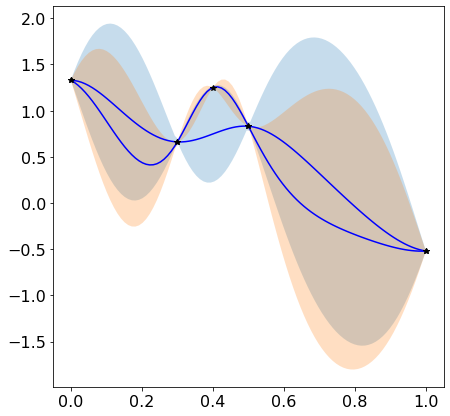

In [9]:
n_dim = 1
prev_x = torch.tensor([0.3])
train_x, train_y = init_data(n_init=3)
train = False

model = init_model(
    n_dim=n_dim, prev_x=prev_x, 
    train_x=train_x, train_y=train_y,
    train=train)

draw_posterior(n_dim=n_dim, model=model)
plt.plot(
    train_x.squeeze().cpu().numpy(), 
    train_y.squeeze().cpu().numpy(), 'k*')

train_x = torch.cat([train_x, torch.tensor([[0.4]])])
train_y = torch.cat([train_y, torch.tensor([1.25])])

model = init_model(
    n_dim=n_dim, prev_x=prev_x, 
    train_x=train_x, train_y=train_y,
    train=train)

draw_posterior(n_dim=n_dim, model=model)
plt.plot(
    train_x.squeeze().cpu().numpy(), 
    train_y.squeeze().cpu().numpy(), 'k*')

In [ ]:
#@title 1D

if oneD:
    save = True
    n_dim = 1
    dim_xi = [n_dim]
    prev_x = torch.tensor([0.3])
    neighbor_size = 0.1
    budget = 6

    ehig_opt_epoch = 200
    ehig_opt_lr = 0.1
    use_lr_schedule = False
    train = False

    train_x, train_y = init_data(n_init=5)

    model = init_model(
        n_dim=n_dim, prev_x=prev_x, 
        train_x=train_x, train_y=train_y,
        train=train)
    
    horizon = budget
    for step in range(budget):

        best_result = argmax_ehig(
            model, prev_x, horizon=horizon, 
            ehig_opt_epoch=ehig_opt_epoch, 
            ehig_opt_lr=ehig_opt_lr, 
            neighbor_size=neighbor_size,
            use_lr_schedule=use_lr_schedule)
        
        horizon = horizon - 1

        next_x = best_result[0]
        next_y = func(next_x.reshape(-1, n_dim))

        # update data and model
        train_x = torch.cat([train_x, next_x.reshape(-1, n_dim)])
        train_y = torch.cat([train_y, next_y])

        model = init_model(
            n_dim=n_dim, prev_x=prev_x, 
            train_x=train_x, train_y=train_y,
            train=train)

        # plot & update prev_x
        if n_dim == 1: ground_truth(draw_true_model=True, n_dim=n_dim)

        plt.title(f'Step {step} with horizon of {horizon}')

        draw_posterior(n_dim=n_dim, model=model)
        plt.plot(
            train_x.squeeze().cpu().numpy(), 
            train_y.squeeze().cpu().numpy(), 'k*')

        plt.vlines(
            prev_x, -1.5, 1.5, color='black', label='Current location')
        plt.vlines(prev_x - neighbor_size, 
                   -1.5, 1.5, color='black', linestyle='--')
        plt.vlines(prev_x + neighbor_size, 
                   -1.5, 1.5, color='black', linestyle='--')

        prev_x = next_x

        plt.vlines(best_result[0], -1.5, 1.5, 
                   color='red', label='Optimal query')
        plt.vlines(best_result[-1], -1.5, 1.5, 
                   color='green', label='Optimal action')

        plt.tight_layout()
        plt.ylim(-1.5, 1.5)
        plt.legend()

        if save: plt.savefig(
            f'{path}/1D/step{step}.{imgtype}', 
            dpi=dpi, bbox_inches='tight')

        plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/gpytorch/lazy/lazy_tensor.py:1811: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution
  1%|          | 1/100 [00:13<22:43, 13.77s/it]

x0:  [[0.4175622761249542, 0.4060685634613037]] , a:  [[0.7310532927513123, 0.6539832949638367]] , loss:  -1.4188477322448316


 11%|█         | 11/100 [01:32<10:57,  7.38s/it]

x0:  [[0.42315030097961426, 0.40714049339294434]] , a:  [[0.8209535479545593, 0.6378521919250488]] , loss:  -1.6084990231204268


 21%|██        | 21/100 [02:45<09:27,  7.19s/it]

x0:  [[0.4251171052455902, 0.4107949137687683]] , a:  [[0.8006623983383179, 0.6536561846733093]] , loss:  -1.6201627342287088


 31%|███       | 31/100 [03:58<08:24,  7.31s/it]

x0:  [[0.428888201713562, 0.41204532980918884]] , a:  [[0.8042901754379272, 0.6497163772583008]] , loss:  -1.6250727825003721


 41%|████      | 41/100 [05:08<07:01,  7.14s/it]

x0:  [[0.4325988292694092, 0.41284993290901184]] , a:  [[0.8092539310455322, 0.6465776562690735]] , loss:  -1.6296248508841213


 51%|█████     | 51/100 [06:21<06:02,  7.40s/it]

x0:  [[0.43574258685112, 0.4142291843891144]] , a:  [[0.8038783073425293, 0.6543421745300293]] , loss:  -1.633895663849166


 61%|██████    | 61/100 [07:31<04:31,  6.96s/it]

x0:  [[0.43847745656967163, 0.41529619693756104]] , a:  [[0.81055748462677, 0.6483968496322632]] , loss:  -1.6381280662225812


 71%|███████   | 71/100 [08:41<03:22,  6.97s/it]

x0:  [[0.4405749440193176, 0.4170621931552887]] , a:  [[0.8089107871055603, 0.6515413522720337]] , loss:  -1.6418687483889647


 81%|████████  | 81/100 [09:51<02:12,  6.95s/it]

x0:  [[0.4422447085380554, 0.418874591588974]] , a:  [[0.809135377407074, 0.6518474221229553]] , loss:  -1.6449045072228243


 91%|█████████ | 91/100 [11:01<01:02,  6.99s/it]

x0:  [[0.44355639815330505, 0.42052367329597473]] , a:  [[0.8107557892799377, 0.6493670344352722]] , loss:  -1.647576823282111


100%|██████████| 100/100 [12:05<00:00,  7.25s/it]


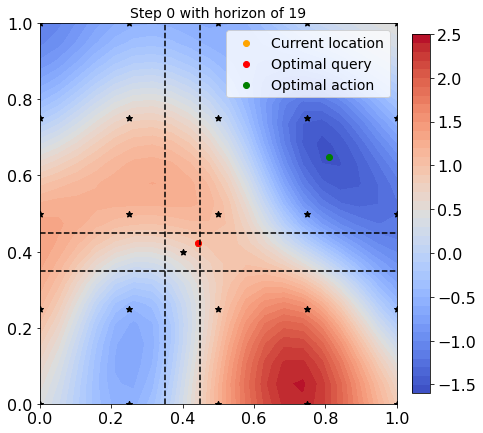

  1%|          | 1/100 [00:06<10:49,  6.56s/it]

x0:  [[0.4561411440372467, 0.4383540749549866]] , a:  [[0.6931253671646118, 0.6113443970680237]] , loss:  -1.059395030940931


 11%|█         | 11/100 [01:11<09:38,  6.51s/it]

x0:  [[0.4649735987186432, 0.4391716420650482]] , a:  [[0.8275589942932129, 0.5948284268379211]] , loss:  -1.562726119429685


 21%|██        | 21/100 [02:19<08:45,  6.65s/it]

x0:  [[0.46873268485069275, 0.4444250464439392]] , a:  [[0.812964677810669, 0.6809139251708984]] , loss:  -1.6144809697930764


 31%|███       | 31/100 [03:24<07:30,  6.52s/it]

x0:  [[0.4722736179828644, 0.44469812512397766]] , a:  [[0.8174328207969666, 0.6445269584655762]] , loss:  -1.6435908396123269


 41%|████      | 41/100 [04:31<06:37,  6.75s/it]

x0:  [[0.4748508632183075, 0.4464641213417053]] , a:  [[0.8116137981414795, 0.6383678317070007]] , loss:  -1.6464000659607088


 51%|█████     | 51/100 [05:35<05:16,  6.46s/it]

x0:  [[0.47704681754112244, 0.4488779604434967]] , a:  [[0.8125827312469482, 0.6493805050849915]] , loss:  -1.6523240635718661


 61%|██████    | 61/100 [06:40<04:13,  6.49s/it]

x0:  [[0.47891154885292053, 0.45056504011154175]] , a:  [[0.8199360966682434, 0.6443472504615784]] , loss:  -1.6549240827512353


 71%|███████   | 71/100 [07:47<03:09,  6.53s/it]

x0:  [[0.48023679852485657, 0.45228296518325806]] , a:  [[0.8167031407356262, 0.6467525362968445]] , loss:  -1.657437704317554


 81%|████████  | 81/100 [08:52<02:02,  6.46s/it]

x0:  [[0.4813675880432129, 0.45359548926353455]] , a:  [[0.8183847665786743, 0.6427911520004272]] , loss:  -1.6594185392615024


 91%|█████████ | 91/100 [09:59<00:59,  6.61s/it]

x0:  [[0.4822781980037689, 0.454832524061203]] , a:  [[0.8175954222679138, 0.6431638598442078]] , loss:  -1.6611311918500566


100%|██████████| 100/100 [10:58<00:00,  6.58s/it]


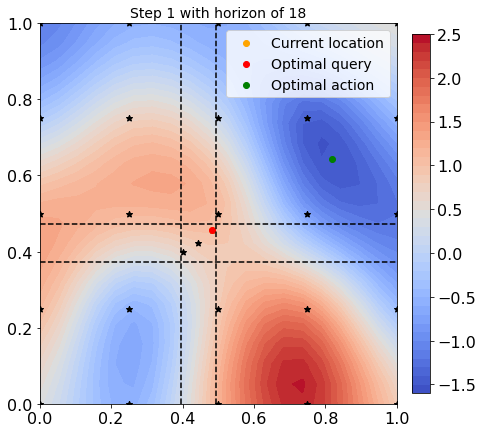

  1%|          | 1/100 [00:06<10:16,  6.23s/it]

x0:  [[0.4866790473461151, 0.45589110255241394]] , a:  [[0.7361283302307129, 0.6343750953674316]] , loss:  -1.3745912255478328


 11%|█         | 11/100 [01:13<10:04,  6.79s/it]

x0:  [[0.4928189814090729, 0.43936923146247864]] , a:  [[0.8198004961013794, 0.6065512299537659]] , loss:  -1.590261844531902


 21%|██        | 21/100 [02:17<08:29,  6.45s/it]

x0:  [[0.4953940510749817, 0.44020941853523254]] , a:  [[0.7943398952484131, 0.6565908789634705]] , loss:  -1.6238574287674938


 31%|███       | 31/100 [03:22<07:50,  6.82s/it]

x0:  [[0.5016945600509644, 0.43824923038482666]] , a:  [[0.827269971370697, 0.6370251774787903]] , loss:  -1.6381368739432363


 41%|████      | 41/100 [04:24<06:04,  6.18s/it]

x0:  [[0.5062615275382996, 0.439353883266449]] , a:  [[0.8150933384895325, 0.6547570824623108]] , loss:  -1.645465426102357


 51%|█████     | 51/100 [05:25<04:57,  6.07s/it]

x0:  [[0.511281430721283, 0.43885180354118347]] , a:  [[0.8233603239059448, 0.6416030526161194]] , loss:  -1.6516172541899408


 61%|██████    | 61/100 [06:28<03:59,  6.15s/it]

x0:  [[0.5152392983436584, 0.43944835662841797]] , a:  [[0.8180426359176636, 0.6463490128517151]] , loss:  -1.6560624173107437


 71%|███████   | 71/100 [07:29<02:57,  6.12s/it]

x0:  [[0.5185682773590088, 0.4393058121204376]] , a:  [[0.8206077814102173, 0.6418082118034363]] , loss:  -1.6593000275600602


 81%|████████  | 81/100 [08:32<02:01,  6.40s/it]

x0:  [[0.5211233496665955, 0.43933114409446716]] , a:  [[0.819713830947876, 0.642243504524231]] , loss:  -1.6618038077352313


 91%|█████████ | 91/100 [09:33<00:55,  6.20s/it]

x0:  [[0.5231226086616516, 0.4392133355140686]] , a:  [[0.8198654055595398, 0.641498863697052]] , loss:  -1.6637701212195042


100%|██████████| 100/100 [10:30<00:00,  6.30s/it]


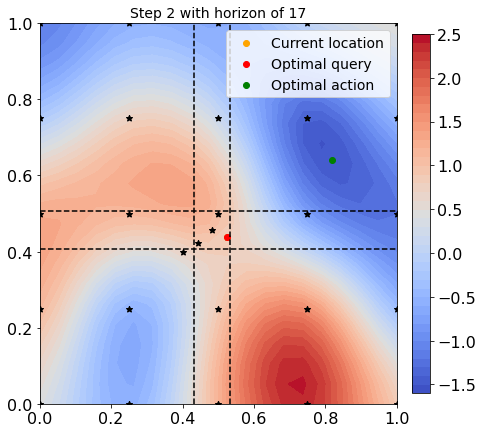

  1%|          | 1/100 [00:05<09:13,  5.59s/it]

x0:  [[0.545011043548584, 0.45717114210128784]] , a:  [[0.7260106801986694, 0.6510935425758362]] , loss:  -1.291681479674694


 11%|█         | 11/100 [01:05<08:38,  5.82s/it]

x0:  [[0.549714207649231, 0.4540591537952423]] , a:  [[0.8250993490219116, 0.5985524654388428]] , loss:  -1.5448119970467367


 21%|██        | 21/100 [02:04<07:47,  5.91s/it]

x0:  [[0.5498303174972534, 0.46114635467529297]] , a:  [[0.794518768787384, 0.6719986796379089]] , loss:  -1.6082716471270155


 31%|███       | 31/100 [03:04<06:53,  5.99s/it]

x0:  [[0.5538753867149353, 0.4623481035232544]] , a:  [[0.8277696371078491, 0.6449909806251526]] , loss:  -1.6210526163369572


 41%|████      | 41/100 [04:03<05:46,  5.88s/it]

x0:  [[0.5563966035842896, 0.4661802351474762]] , a:  [[0.8096556663513184, 0.6569338440895081]] , loss:  -1.6324167505075289


 51%|█████     | 51/100 [05:01<04:47,  5.86s/it]

x0:  [[0.5596490502357483, 0.4679100811481476]] , a:  [[0.8171038627624512, 0.6419406533241272]] , loss:  -1.6379575732610752


 61%|██████    | 61/100 [06:01<03:45,  5.78s/it]

x0:  [[0.562262237071991, 0.4695972800254822]] , a:  [[0.8120418787002563, 0.6479136943817139]] , loss:  -1.6415585525150103


 71%|███████   | 71/100 [06:58<02:44,  5.69s/it]

x0:  [[0.5644927024841309, 0.47043195366859436]] , a:  [[0.8157011270523071, 0.6438849568367004]] , loss:  -1.644539092736775


 81%|████████  | 81/100 [07:57<01:50,  5.83s/it]

x0:  [[0.5661855340003967, 0.47144973278045654]] , a:  [[0.8140029311180115, 0.6463655829429626]] , loss:  -1.6468743745861643


 91%|█████████ | 91/100 [08:53<00:51,  5.67s/it]

x0:  [[0.56751549243927, 0.47235316038131714]] , a:  [[0.8151746988296509, 0.6449211239814758]] , loss:  -1.6487628150034503


100%|██████████| 100/100 [09:44<00:00,  5.85s/it]


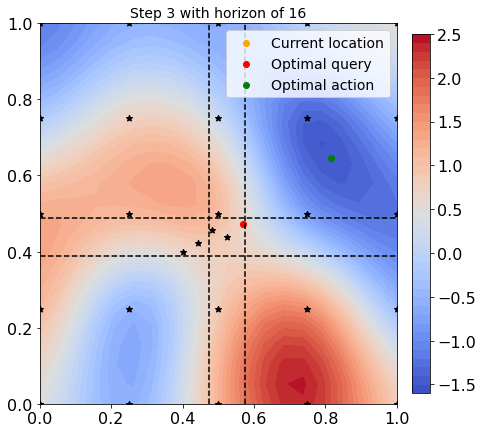

  1%|          | 1/100 [00:05<08:39,  5.25s/it]

x0:  [[0.572459876537323, 0.4853610098361969]] , a:  [[0.782110333442688, 0.6340372562408447]] , loss:  -1.517704712779869


 11%|█         | 11/100 [00:59<07:57,  5.36s/it]

x0:  [[0.5793222784996033, 0.4780397117137909]] , a:  [[0.8194251656532288, 0.6486607193946838]] , loss:  -1.6245379691268667


 21%|██        | 21/100 [01:53<07:02,  5.35s/it]

x0:  [[0.5853133201599121, 0.47766706347465515]] , a:  [[0.806488037109375, 0.6501956582069397]] , loss:  -1.6359789456923126


 31%|███       | 31/100 [02:49<06:30,  5.66s/it]

x0:  [[0.592349648475647, 0.48391586542129517]] , a:  [[0.808000922203064, 0.646429181098938]] , loss:  -1.6448176549390316


 41%|████      | 41/100 [03:41<05:12,  5.30s/it]

x0:  [[0.5991223454475403, 0.4865024983882904]] , a:  [[0.8131290674209595, 0.6420668363571167]] , loss:  -1.6520937952984258


 51%|█████     | 51/100 [04:35<04:19,  5.30s/it]

x0:  [[0.6043774485588074, 0.48703533411026]] , a:  [[0.8116742372512817, 0.6454271078109741]] , loss:  -1.658239372012815


 61%|██████    | 61/100 [05:31<03:35,  5.52s/it]

x0:  [[0.6081209778785706, 0.4881155490875244]] , a:  [[0.8125004172325134, 0.6457492709159851]] , loss:  -1.6624652336387884


 71%|███████   | 71/100 [06:25<02:36,  5.41s/it]

x0:  [[0.6106425523757935, 0.48970770835876465]] , a:  [[0.8135875463485718, 0.6445536613464355]] , loss:  -1.6654138423170703


 81%|████████  | 81/100 [07:18<01:41,  5.35s/it]

x0:  [[0.6123338341712952, 0.4905281960964203]] , a:  [[0.8133589029312134, 0.6435670852661133]] , loss:  -1.6675728247242942


 91%|█████████ | 91/100 [08:13<00:48,  5.34s/it]

x0:  [[0.6134921312332153, 0.4908556044101715]] , a:  [[0.8128337264060974, 0.6433379650115967]] , loss:  -1.6692077699058052


100%|██████████| 100/100 [09:02<00:00,  5.42s/it]


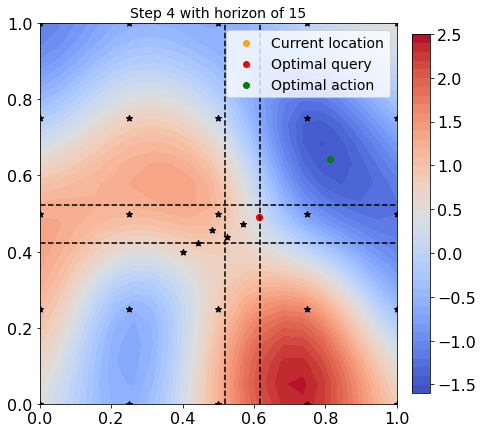

  1%|          | 1/100 [00:05<08:18,  5.04s/it]

x0:  [[0.6236763000488281, 0.49775955080986023]] , a:  [[0.8345414996147156, 0.6871239542961121]] , loss:  -1.5078038237994418


 11%|█         | 11/100 [00:56<07:53,  5.32s/it]

x0:  [[0.6156177520751953, 0.502504825592041]] , a:  [[0.8189048767089844, 0.6402034759521484]] , loss:  -1.5930684499628116


 21%|██        | 21/100 [01:45<06:34,  4.99s/it]

x0:  [[0.629993736743927, 0.4918960928916931]] , a:  [[0.7945579886436462, 0.6569471955299377]] , loss:  -1.651201174655582


 31%|███       | 31/100 [02:35<05:41,  4.95s/it]

x0:  [[0.6404019594192505, 0.49868687987327576]] , a:  [[0.8168010115623474, 0.6405594348907471]] , loss:  -1.6692274280360866


 41%|████      | 41/100 [03:26<05:07,  5.22s/it]

x0:  [[0.6472721099853516, 0.4994470477104187]] , a:  [[0.8146759271621704, 0.6439077854156494]] , loss:  -1.6796941363223112


 51%|█████     | 51/100 [04:15<04:02,  4.95s/it]

x0:  [[0.6518325209617615, 0.49790725111961365]] , a:  [[0.8083586692810059, 0.6451822519302368]] , loss:  -1.686497312152553


 61%|██████    | 61/100 [05:05<03:13,  4.97s/it]

x0:  [[0.6547560691833496, 0.49898701906204224]] , a:  [[0.8093265295028687, 0.6423516869544983]] , loss:  -1.6908290437106415


 71%|███████   | 71/100 [05:56<02:27,  5.09s/it]

x0:  [[0.6567590832710266, 0.4990415573120117]] , a:  [[0.8107399344444275, 0.6433666348457336]] , loss:  -1.6937989163035365


 81%|████████  | 81/100 [06:46<01:35,  5.01s/it]

x0:  [[0.6581535935401917, 0.498888224363327]] , a:  [[0.8109046220779419, 0.6417495608329773]] , loss:  -1.6959187065006764


 91%|█████████ | 91/100 [07:37<00:46,  5.15s/it]

x0:  [[0.6591526865959167, 0.4990581274032593]] , a:  [[0.8115012645721436, 0.6419458389282227]] , loss:  -1.6974332047157903


100%|██████████| 100/100 [08:27<00:00,  5.08s/it]


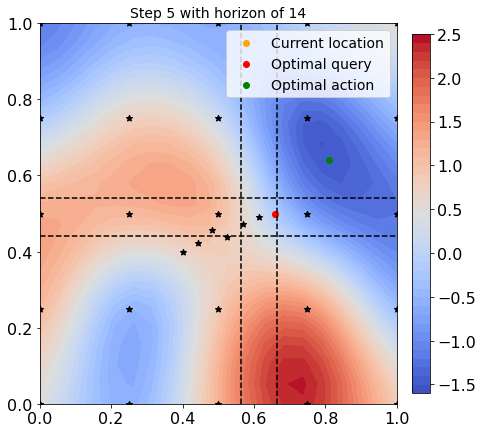

  1%|          | 1/100 [00:05<08:26,  5.12s/it]

x0:  [[0.6730735301971436, 0.5218285322189331]] , a:  [[0.861770749092102, 0.6743565797805786]] , loss:  -1.4372890388618964


 11%|█         | 11/100 [00:55<07:24,  5.00s/it]

x0:  [[0.6540120244026184, 0.5278213620185852]] , a:  [[0.7999629974365234, 0.658738911151886]] , loss:  -1.6097289578993716


 21%|██        | 21/100 [01:46<06:54,  5.24s/it]

x0:  [[0.6431766152381897, 0.5334985852241516]] , a:  [[0.7999994158744812, 0.6643843650817871]] , loss:  -1.6139773933721229


 31%|███       | 31/100 [02:35<05:28,  4.77s/it]

x0:  [[0.6413754820823669, 0.5369948148727417]] , a:  [[0.8103638291358948, 0.6533471941947937]] , loss:  -1.6163951329815351


 41%|████      | 41/100 [03:22<04:31,  4.61s/it]

x0:  [[0.6433307528495789, 0.539771556854248]] , a:  [[0.8058373928070068, 0.6596526503562927]] , loss:  -1.6206213441971304


 51%|█████     | 51/100 [04:09<04:07,  5.05s/it]

x0:  [[0.647171676158905, 0.5418045520782471]] , a:  [[0.8055084943771362, 0.6593878269195557]] , loss:  -1.6234651445413062


 61%|██████    | 61/100 [04:56<03:08,  4.84s/it]

x0:  [[0.6504145264625549, 0.5433870553970337]] , a:  [[0.8065406084060669, 0.6579540967941284]] , loss:  -1.6261758432806637


 71%|███████   | 71/100 [05:46<02:24,  4.97s/it]

x0:  [[0.6514712572097778, 0.5446486473083496]] , a:  [[0.806317150592804, 0.6593703031539917]] , loss:  -1.6275265673650308


 81%|████████  | 81/100 [06:39<01:40,  5.30s/it]

x0:  [[0.6513707041740417, 0.5455947518348694]] , a:  [[0.8086612224578857, 0.6570206880569458]] , loss:  -1.6298415767455259


 91%|█████████ | 91/100 [07:31<00:46,  5.16s/it]

x0:  [[0.6501523852348328, 0.5463204383850098]] , a:  [[0.805973470211029, 0.6582362055778503]] , loss:  -1.6324731684591616


100%|██████████| 100/100 [08:17<00:00,  4.97s/it]


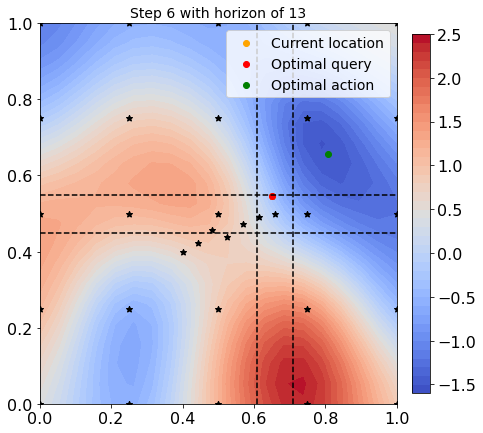

  1%|          | 1/100 [00:04<07:30,  4.55s/it]

x0:  [[0.6554398536682129, 0.5555661916732788]] , a:  [[0.7932143807411194, 0.7286940813064575]] , loss:  -1.484407475964303


 11%|█         | 11/100 [00:53<07:12,  4.86s/it]

x0:  [[0.649729311466217, 0.5605194568634033]] , a:  [[0.8034186959266663, 0.6638000011444092]] , loss:  -1.6226709521322211


 21%|██        | 21/100 [01:40<06:05,  4.62s/it]

x0:  [[0.6527190804481506, 0.568181037902832]] , a:  [[0.8131505250930786, 0.6541339159011841]] , loss:  -1.6363514243428676


 31%|███       | 31/100 [02:27<05:25,  4.71s/it]

x0:  [[0.6529776453971863, 0.5733450055122375]] , a:  [[0.8117667436599731, 0.6541252136230469]] , loss:  -1.6383180508129824


 41%|████      | 41/100 [03:15<04:37,  4.70s/it]

x0:  [[0.652802586555481, 0.5772784352302551]] , a:  [[0.8074235320091248, 0.6551154255867004]] , loss:  -1.6434537010990617


 51%|█████     | 51/100 [04:02<03:52,  4.74s/it]

x0:  [[0.6549038887023926, 0.580430805683136]] , a:  [[0.809799313545227, 0.6558072566986084]] , loss:  -1.64864348208701


 61%|██████    | 61/100 [04:50<03:06,  4.79s/it]

x0:  [[0.6563143730163574, 0.5833203792572021]] , a:  [[0.8105340003967285, 0.6535606384277344]] , loss:  -1.65278105652118


 71%|███████   | 71/100 [05:39<02:16,  4.72s/it]

x0:  [[0.6558131575584412, 0.585918128490448]] , a:  [[0.8093666434288025, 0.6534443497657776]] , loss:  -1.657775598223342


 81%|████████  | 81/100 [06:26<01:30,  4.78s/it]

x0:  [[0.6550909280776978, 0.5879583954811096]] , a:  [[0.8080928325653076, 0.6529894471168518]] , loss:  -1.6654225758372398


 91%|█████████ | 91/100 [07:16<00:47,  5.25s/it]

x0:  [[0.6570785045623779, 0.5893934369087219]] , a:  [[0.8081532716751099, 0.6514938473701477]] , loss:  -1.6632117462697769


100%|██████████| 100/100 [07:58<00:00,  4.79s/it]


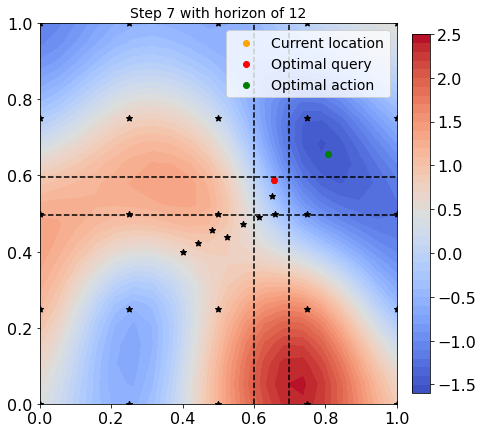

  1%|          | 1/100 [00:04<06:48,  4.13s/it]

x0:  [[0.6712329387664795, 0.6055261492729187]] , a:  [[0.820465624332428, 0.7787045240402222]] , loss:  -1.2690113504225546


 11%|█         | 11/100 [00:47<06:25,  4.33s/it]

x0:  [[0.6549222469329834, 0.6053699254989624]] , a:  [[0.8315250873565674, 0.6423802971839905]] , loss:  -1.6430951512480905


 21%|██        | 21/100 [01:32<06:08,  4.66s/it]

x0:  [[0.658894956111908, 0.6140854358673096]] , a:  [[0.7965295314788818, 0.6575831174850464]] , loss:  -1.6736272703835657


 31%|███       | 31/100 [02:16<05:03,  4.40s/it]

x0:  [[0.6631529927253723, 0.6187625527381897]] , a:  [[0.8107548356056213, 0.6520798802375793]] , loss:  -1.675743062679102


 41%|████      | 41/100 [02:59<04:14,  4.31s/it]

x0:  [[0.6604504585266113, 0.6225495934486389]] , a:  [[0.8005587458610535, 0.6614192128181458]] , loss:  -1.6818579839905574


 51%|█████     | 51/100 [03:43<03:41,  4.52s/it]

x0:  [[0.6626664400100708, 0.6245996952056885]] , a:  [[0.8094856142997742, 0.6542394161224365]] , loss:  -1.685222643767565


 61%|██████    | 61/100 [04:26<02:43,  4.19s/it]

x0:  [[0.6642230153083801, 0.6263288855552673]] , a:  [[0.8038123846054077, 0.658266544342041]] , loss:  -1.688213460567562


 71%|███████   | 71/100 [05:08<01:59,  4.12s/it]

x0:  [[0.6635757088661194, 0.627967119216919]] , a:  [[0.8049944043159485, 0.6556596159934998]] , loss:  -1.6912546878693366


 81%|████████  | 81/100 [05:49<01:18,  4.14s/it]

x0:  [[0.663381040096283, 0.6293161511421204]] , a:  [[0.8052472472190857, 0.6542928814888]] , loss:  -1.694820088213168


 91%|█████████ | 91/100 [06:32<00:38,  4.25s/it]

x0:  [[0.6611906886100769, 0.6304566860198975]] , a:  [[0.7955508828163147, 0.6651939749717712]] , loss:  -1.6897641572130053


100%|██████████| 100/100 [07:10<00:00,  4.30s/it]


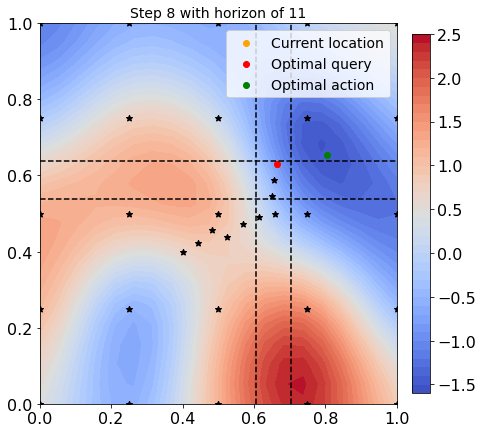

  1%|          | 1/100 [00:03<05:54,  3.58s/it]

x0:  [[0.672446608543396, 0.6504035592079163]] , a:  [[0.8319109678268433, 0.7773289680480957]] , loss:  -1.217986999417972


 11%|█         | 11/100 [00:39<05:23,  3.64s/it]

x0:  [[0.6691447496414185, 0.6476573944091797]] , a:  [[0.8211871385574341, 0.6391766667366028]] , loss:  -1.6759213916899818


 21%|██        | 21/100 [01:19<05:20,  4.05s/it]

x0:  [[0.6728811264038086, 0.65422123670578]] , a:  [[0.8014809489250183, 0.6593952178955078]] , loss:  -1.6977365418387274


 31%|███       | 31/100 [01:57<04:25,  3.85s/it]

x0:  [[0.6750377416610718, 0.6582216620445251]] , a:  [[0.80965656042099, 0.6671845316886902]] , loss:  -1.7008966146576698


 41%|████      | 41/100 [02:35<03:48,  3.87s/it]

x0:  [[0.6744167804718018, 0.6610788106918335]] , a:  [[0.802730917930603, 0.6600158214569092]] , loss:  -1.7055201446288442


 51%|█████     | 51/100 [03:14<03:11,  3.90s/it]

x0:  [[0.677209734916687, 0.6625341773033142]] , a:  [[0.8042386174201965, 0.6585290431976318]] , loss:  -1.707911278056902


 61%|██████    | 61/100 [03:54<02:29,  3.84s/it]

x0:  [[0.6773988008499146, 0.66445392370224]] , a:  [[0.8040183782577515, 0.6633780002593994]] , loss:  -1.7104572395406168


 71%|███████   | 71/100 [04:33<01:52,  3.87s/it]

x0:  [[0.6783490180969238, 0.6659514904022217]] , a:  [[0.8072813153266907, 0.6612851619720459]] , loss:  -1.7121666622855


 81%|████████  | 81/100 [05:11<01:12,  3.82s/it]

x0:  [[0.6795719265937805, 0.6672845482826233]] , a:  [[0.8055397272109985, 0.6625934839248657]] , loss:  -1.7136118152946407


 91%|█████████ | 91/100 [05:49<00:34,  3.88s/it]

x0:  [[0.6802369356155396, 0.6686295866966248]] , a:  [[0.8057318925857544, 0.6619927287101746]] , loss:  -1.7147951461184847


100%|██████████| 100/100 [06:23<00:00,  3.83s/it]


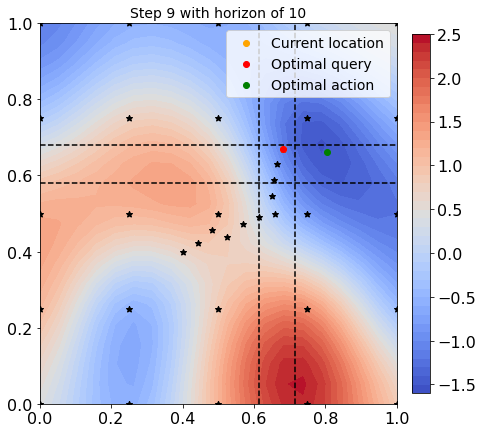

  1%|          | 1/100 [00:03<05:25,  3.29s/it]

x0:  [[0.7039197683334351, 0.6794711947441101]] , a:  [[0.7730870842933655, 0.7976941466331482]] , loss:  -1.2547965780907349


 11%|█         | 11/100 [00:36<04:58,  3.36s/it]

x0:  [[0.7042426466941833, 0.6749536991119385]] , a:  [[0.8297121524810791, 0.6427487134933472]] , loss:  -1.5674847959441924


 21%|██        | 21/100 [01:10<04:23,  3.34s/it]

x0:  [[0.7111543416976929, 0.6874198913574219]] , a:  [[0.8100018501281738, 0.6564248204231262]] , loss:  -1.6193999359653173


 31%|███       | 31/100 [01:45<03:57,  3.45s/it]

x0:  [[0.6996729373931885, 0.7028186321258545]] , a:  [[0.7993245124816895, 0.66586834192276]] , loss:  -1.7175896075350818


 41%|████      | 41/100 [02:19<03:17,  3.34s/it]

x0:  [[0.7057676315307617, 0.706497311592102]] , a:  [[0.8065211772918701, 0.6575068831443787]] , loss:  -1.722792703183102


 51%|█████     | 51/100 [02:53<02:44,  3.36s/it]

x0:  [[0.709103524684906, 0.7080755829811096]] , a:  [[0.8066926002502441, 0.6600731611251831]] , loss:  -1.7295841976534074


 61%|██████    | 61/100 [03:27<02:13,  3.43s/it]

x0:  [[0.7075658440589905, 0.7096914052963257]] , a:  [[0.8035679459571838, 0.6652611494064331]] , loss:  -1.737710966707722


 71%|███████   | 71/100 [04:02<01:39,  3.43s/it]

x0:  [[0.7096449732780457, 0.7101452350616455]] , a:  [[0.8082507848739624, 0.658925473690033]] , loss:  -1.743697052561515


 81%|████████  | 81/100 [04:35<01:02,  3.30s/it]

x0:  [[0.7094604969024658, 0.7109406590461731]] , a:  [[0.8061039447784424, 0.6623581647872925]] , loss:  -1.745310077471852


 91%|█████████ | 91/100 [05:10<00:30,  3.44s/it]

x0:  [[0.7100870609283447, 0.7115157842636108]] , a:  [[0.8056166768074036, 0.6609851121902466]] , loss:  -1.7471492353366613


100%|██████████| 100/100 [05:40<00:00,  3.40s/it]


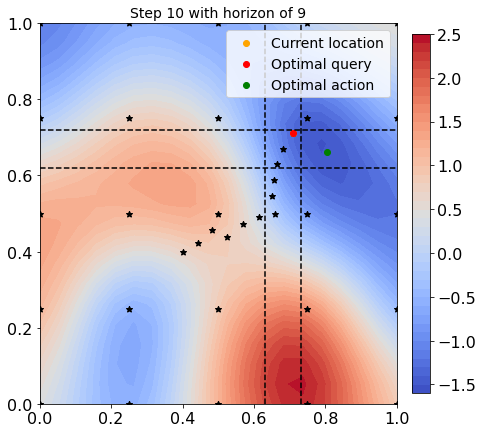

  1%|          | 1/100 [00:02<04:42,  2.85s/it]

x0:  [[0.7247917652130127, 0.727867603302002]] , a:  [[0.8366829752922058, 0.8064529895782471]] , loss:  -1.0180868064615434


 11%|█         | 11/100 [00:33<04:23,  2.96s/it]

x0:  [[0.7106611728668213, 0.7369508743286133]] , a:  [[0.771819531917572, 0.6424854397773743]] , loss:  -1.5828350492857102


 21%|██        | 21/100 [01:03<03:56,  2.99s/it]

x0:  [[0.7062516808509827, 0.7427634596824646]] , a:  [[0.8367261290550232, 0.6411924362182617]] , loss:  -1.607643228800627


 31%|███       | 31/100 [01:33<03:24,  2.97s/it]

x0:  [[0.698934018611908, 0.7460252642631531]] , a:  [[0.7955779433250427, 0.6526037454605103]] , loss:  -1.6651959681054083


 41%|████      | 41/100 [02:03<02:57,  3.01s/it]

x0:  [[0.6928872466087341, 0.7473849058151245]] , a:  [[0.8008008003234863, 0.6621527075767517]] , loss:  -1.682001717489025


 51%|█████     | 51/100 [02:34<02:47,  3.41s/it]

x0:  [[0.6884080171585083, 0.7473536729812622]] , a:  [[0.8117957711219788, 0.6494621634483337]] , loss:  -1.6919102055688409


 61%|██████    | 61/100 [03:04<01:56,  2.99s/it]

x0:  [[0.6851592063903809, 0.7468067407608032]] , a:  [[0.8027579188346863, 0.6576398015022278]] , loss:  -1.7002721883169742


 71%|███████   | 71/100 [03:34<01:25,  2.96s/it]

x0:  [[0.6808744668960571, 0.7492665648460388]] , a:  [[0.8046349883079529, 0.6578390598297119]] , loss:  -1.7000275548520662


 81%|████████  | 81/100 [04:03<00:56,  2.95s/it]

x0:  [[0.6786653995513916, 0.7503366470336914]] , a:  [[0.8091274499893188, 0.6545047760009766]] , loss:  -1.7019270168245058


 91%|█████████ | 91/100 [04:33<00:26,  2.98s/it]

x0:  [[0.6772329807281494, 0.7502796053886414]] , a:  [[0.8049452900886536, 0.658437192440033]] , loss:  -1.7043231106112813


100%|██████████| 100/100 [05:01<00:00,  3.02s/it]


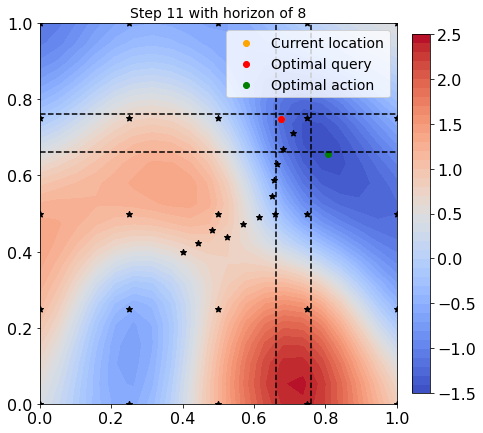

  1%|          | 1/100 [00:02<04:11,  2.54s/it]

x0:  [[0.6847609877586365, 0.7549715042114258]] , a:  [[0.7634087204933167, 0.8497650027275085]] , loss:  -0.8032848624305692


 11%|█         | 11/100 [00:28<03:47,  2.55s/it]

x0:  [[0.6801541447639465, 0.7351488471031189]] , a:  [[0.8201174736022949, 0.6534779071807861]] , loss:  -1.6081087456804248


 21%|██        | 21/100 [00:53<03:22,  2.57s/it]

x0:  [[0.668686032295227, 0.7295039296150208]] , a:  [[0.8298414349555969, 0.6046050786972046]] , loss:  -1.5524611517854654


 31%|███       | 31/100 [01:19<02:55,  2.54s/it]

x0:  [[0.6711716651916504, 0.7344833016395569]] , a:  [[0.8082972764968872, 0.6567582488059998]] , loss:  -1.6195350616600879


 41%|████      | 41/100 [01:44<02:31,  2.57s/it]

x0:  [[0.6770015358924866, 0.734671950340271]] , a:  [[0.8031510710716248, 0.674649178981781]] , loss:  -1.6166186826331808


 51%|█████     | 51/100 [02:12<02:10,  2.66s/it]

x0:  [[0.6711432337760925, 0.7304144501686096]] , a:  [[0.8114458918571472, 0.6511057615280151]] , loss:  -1.631195602823843


 61%|██████    | 61/100 [02:38<01:39,  2.55s/it]

x0:  [[0.6745479106903076, 0.728599488735199]] , a:  [[0.8072338700294495, 0.6547833681106567]] , loss:  -1.6380135460993444


 71%|███████   | 71/100 [03:03<01:14,  2.56s/it]

x0:  [[0.6750196218490601, 0.728514552116394]] , a:  [[0.8054599165916443, 0.6633328199386597]] , loss:  -1.6285350188390375


 81%|████████  | 81/100 [03:29<00:48,  2.53s/it]

x0:  [[0.669023871421814, 0.7310981154441833]] , a:  [[0.8092242479324341, 0.6580204367637634]] , loss:  -1.63063979859807


 91%|█████████ | 91/100 [03:54<00:22,  2.54s/it]

x0:  [[0.6724666953086853, 0.7305855751037598]] , a:  [[0.8113425970077515, 0.6519252061843872]] , loss:  -1.6350749388817996


100%|██████████| 100/100 [04:19<00:00,  2.60s/it]


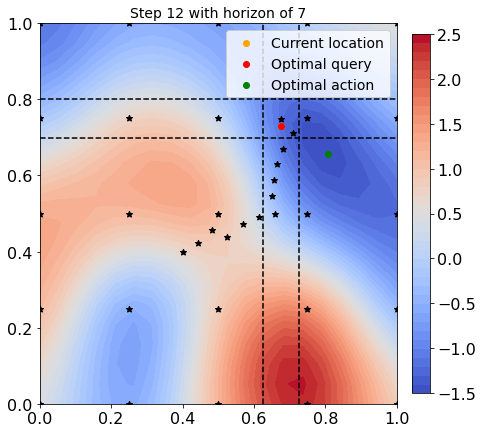

  1%|          | 1/100 [00:02<03:45,  2.28s/it]

x0:  [[0.6946754455566406, 0.7403331995010376]] , a:  [[0.7670208215713501, 0.8381404280662537]] , loss:  -0.909246452971194


 11%|█         | 11/100 [00:25<03:27,  2.33s/it]

x0:  [[0.6933280825614929, 0.7190419435501099]] , a:  [[0.8049861788749695, 0.6683707237243652]] , loss:  -1.5749386616555412


 21%|██        | 21/100 [00:48<03:06,  2.36s/it]

x0:  [[0.678643524646759, 0.7208461165428162]] , a:  [[0.8219539523124695, 0.629697322845459]] , loss:  -1.5638944824496777


 31%|███       | 31/100 [01:11<02:36,  2.26s/it]

x0:  [[0.6712570786476135, 0.7208998799324036]] , a:  [[0.8116378784179688, 0.6542360782623291]] , loss:  -1.6119402947184855


 41%|████      | 41/100 [01:33<02:09,  2.19s/it]

x0:  [[0.6746623516082764, 0.715268075466156]] , a:  [[0.8005505800247192, 0.6641022562980652]] , loss:  -1.6268208217535918


 51%|█████     | 51/100 [01:55<01:46,  2.18s/it]

x0:  [[0.6714184284210205, 0.7114636301994324]] , a:  [[0.8079437017440796, 0.6578819751739502]] , loss:  -1.6342079407780987


 61%|██████    | 61/100 [02:17<01:25,  2.18s/it]

x0:  [[0.6727389693260193, 0.7086688280105591]] , a:  [[0.8100443482398987, 0.6535192728042603]] , loss:  -1.6394527387282125


 71%|███████   | 71/100 [02:38<01:01,  2.12s/it]

x0:  [[0.6724087595939636, 0.7069329619407654]] , a:  [[0.8059561848640442, 0.6602242588996887]] , loss:  -1.6425361076413696


 81%|████████  | 81/100 [03:00<00:40,  2.11s/it]

x0:  [[0.6728471517562866, 0.7057888507843018]] , a:  [[0.8080037832260132, 0.6575673222541809]] , loss:  -1.6420289981057452


 91%|█████████ | 91/100 [03:21<00:18,  2.10s/it]

x0:  [[0.6644883751869202, 0.7132881283760071]] , a:  [[0.8036149740219116, 0.6647248268127441]] , loss:  -1.6152088498090356


100%|██████████| 100/100 [03:39<00:00,  2.20s/it]


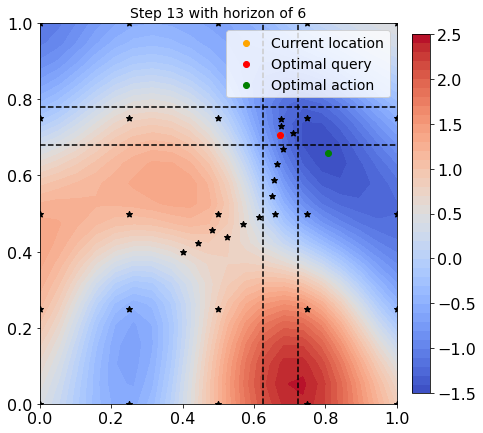

  1%|          | 1/100 [00:01<02:40,  1.62s/it]

x0:  [[0.6786786317825317, 0.7153040766716003]] , a:  [[0.7461965680122375, 0.7951313853263855]] , loss:  -1.2406719085146085


 11%|█         | 11/100 [00:18<02:34,  1.74s/it]

x0:  [[0.6952393054962158, 0.698733389377594]] , a:  [[0.803200364112854, 0.6538006067276001]] , loss:  -1.5997922511665175


 21%|██        | 21/100 [00:36<02:26,  1.86s/it]

x0:  [[0.7030468583106995, 0.705814778804779]] , a:  [[0.8201336860656738, 0.6432974934577942]] , loss:  -1.6002155354429908


 31%|███       | 31/100 [00:54<01:56,  1.68s/it]

x0:  [[0.7086734771728516, 0.7098062634468079]] , a:  [[0.7981288433074951, 0.6671640872955322]] , loss:  -1.619186268290936


 41%|████      | 41/100 [01:11<01:39,  1.69s/it]

x0:  [[0.7086687684059143, 0.7100569605827332]] , a:  [[0.804707407951355, 0.6654980182647705]] , loss:  -1.626272503805423


 51%|█████     | 51/100 [01:28<01:24,  1.72s/it]

x0:  [[0.7081308960914612, 0.7098793387413025]] , a:  [[0.8087050914764404, 0.6574874520301819]] , loss:  -1.6299017443859831


 61%|██████    | 61/100 [01:45<01:07,  1.72s/it]

x0:  [[0.7081936001777649, 0.7100427150726318]] , a:  [[0.8062211871147156, 0.6614605784416199]] , loss:  -1.631611573952201


 71%|███████   | 71/100 [02:02<00:43,  1.49s/it]

x0:  [[0.7084036469459534, 0.7101593613624573]] , a:  [[0.806207537651062, 0.6611253619194031]] , loss:  -1.6328008296482102


 81%|████████  | 81/100 [02:16<00:27,  1.43s/it]

x0:  [[0.70833420753479, 0.7092429399490356]] , a:  [[0.7994440793991089, 0.6675370335578918]] , loss:  -1.6223154722502429


 91%|█████████ | 91/100 [02:30<00:12,  1.42s/it]

x0:  [[0.706040620803833, 0.7085660696029663]] , a:  [[0.8053689002990723, 0.6618525385856628]] , loss:  -1.625166368648026


100%|██████████| 100/100 [02:43<00:00,  1.64s/it]


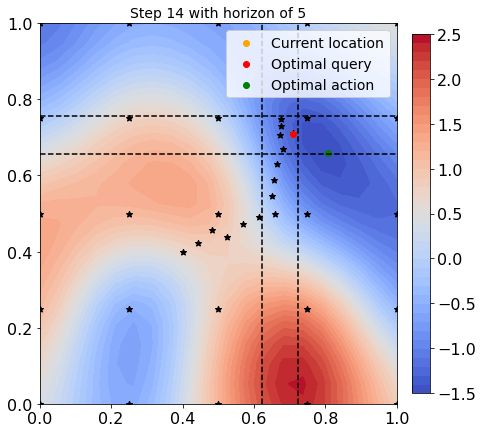

  1%|          | 1/100 [00:01<01:43,  1.05s/it]

x0:  [[0.7122505307197571, 0.7331097722053528]] , a:  [[0.7764139175415039, 0.7617257237434387]] , loss:  -1.3722189061637389


 11%|█         | 11/100 [00:13<01:44,  1.17s/it]

x0:  [[0.6957947015762329, 0.7166004776954651]] , a:  [[0.8039314150810242, 0.6504364609718323]] , loss:  -1.568242355619975


 21%|██        | 21/100 [00:24<01:25,  1.09s/it]

x0:  [[0.6908758282661438, 0.7177903652191162]] , a:  [[0.8138529658317566, 0.6440417766571045]] , loss:  -1.5794965706411312


 31%|███       | 31/100 [00:36<01:18,  1.13s/it]

x0:  [[0.6843706369400024, 0.7153315544128418]] , a:  [[0.8056091070175171, 0.6646801829338074]] , loss:  -1.5996117229345648


 41%|████      | 41/100 [00:46<01:05,  1.11s/it]

x0:  [[0.6764818429946899, 0.7154816389083862]] , a:  [[0.7865204811096191, 0.6735967993736267]] , loss:  -1.6016915405240868


 51%|█████     | 51/100 [00:57<00:54,  1.11s/it]

x0:  [[0.6756169199943542, 0.7196204662322998]] , a:  [[0.8105801343917847, 0.6646530032157898]] , loss:  -1.6063132583158792


 61%|██████    | 61/100 [01:08<00:43,  1.11s/it]

x0:  [[0.6743306517601013, 0.7180638313293457]] , a:  [[0.8041078448295593, 0.6526148319244385]] , loss:  -1.610464437315982


 71%|███████   | 71/100 [01:19<00:32,  1.11s/it]

x0:  [[0.6749684810638428, 0.7181716561317444]] , a:  [[0.8007267713546753, 0.6709105372428894]] , loss:  -1.6144508459434261


 81%|████████  | 81/100 [01:30<00:20,  1.09s/it]

x0:  [[0.6749799847602844, 0.7159743309020996]] , a:  [[0.8055735230445862, 0.6598460078239441]] , loss:  -1.6205539988060282


 91%|█████████ | 91/100 [01:41<00:09,  1.08s/it]

x0:  [[0.6746141910552979, 0.7144565582275391]] , a:  [[0.8022765517234802, 0.6602046489715576]] , loss:  -1.6238378578411925


100%|██████████| 100/100 [01:51<00:00,  1.12s/it]


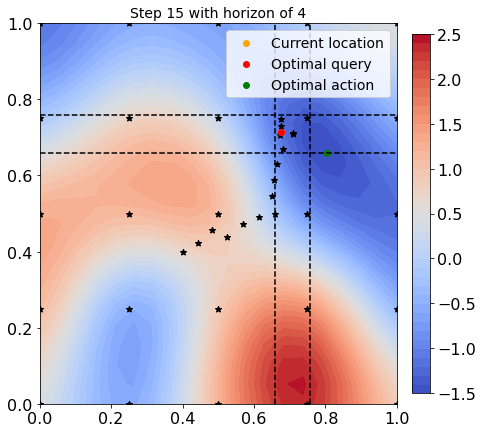

  1%|          | 1/100 [00:00<01:15,  1.31it/s]

x0:  [[0.6865914463996887, 0.7267942428588867]] , a:  [[0.740326464176178, 0.7637476921081543]] , loss:  -1.3430559317031887


 11%|█         | 11/100 [00:08<01:12,  1.23it/s]

x0:  [[0.6877281665802002, 0.7165873050689697]] , a:  [[0.7897413372993469, 0.6780220866203308]] , loss:  -1.5622941814298388


 21%|██        | 21/100 [00:16<01:01,  1.28it/s]

x0:  [[0.687059760093689, 0.7132006883621216]] , a:  [[0.8104082942008972, 0.6451750993728638]] , loss:  -1.5654179387460454


 31%|███       | 31/100 [00:24<00:54,  1.26it/s]

x0:  [[0.686448872089386, 0.7157632112503052]] , a:  [[0.8083226680755615, 0.6567745208740234]] , loss:  -1.5749590637636146


 41%|████      | 41/100 [00:33<00:49,  1.19it/s]

x0:  [[0.6843301057815552, 0.7134551405906677]] , a:  [[0.7939377427101135, 0.6643262505531311]] , loss:  -1.5837176456018185


 51%|█████     | 51/100 [00:42<00:40,  1.21it/s]

x0:  [[0.6756995916366577, 0.7214269042015076]] , a:  [[0.7888723015785217, 0.6858025789260864]] , loss:  -1.5653333685740922


 61%|██████    | 61/100 [00:50<00:30,  1.26it/s]

x0:  [[0.6758351922035217, 0.7226800918579102]] , a:  [[0.7975502014160156, 0.6693882346153259]] , loss:  -1.5682889534869862


 71%|███████   | 71/100 [00:58<00:23,  1.24it/s]

x0:  [[0.6752874851226807, 0.7207226753234863]] , a:  [[0.8015011548995972, 0.6605864763259888]] , loss:  -1.5853781474608155


 81%|████████  | 81/100 [01:06<00:15,  1.23it/s]

x0:  [[0.6752849817276001, 0.7196896076202393]] , a:  [[0.800699770450592, 0.6659665703773499]] , loss:  -1.5907591369358072


 91%|█████████ | 91/100 [01:14<00:06,  1.29it/s]

x0:  [[0.6749188899993896, 0.7188573479652405]] , a:  [[0.7975237965583801, 0.668089747428894]] , loss:  -1.5957861380248923


100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


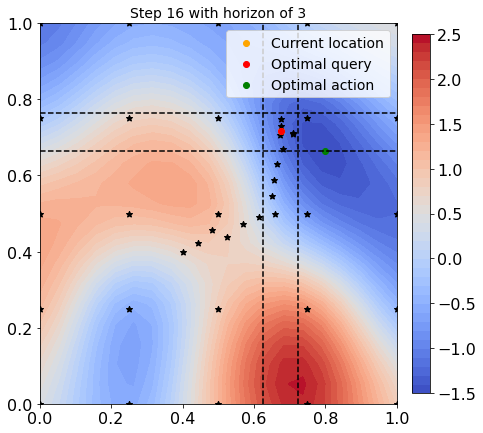

  1%|          | 1/100 [00:00<00:50,  1.96it/s]

x0:  [[0.6943349838256836, 0.7337982654571533]] , a:  [[0.7160146832466125, 0.7572579979896545]] , loss:  -1.3190081602311012


 11%|█         | 11/100 [00:05<00:45,  1.96it/s]

x0:  [[0.699312150478363, 0.7283941507339478]] , a:  [[0.7649082541465759, 0.6996853351593018]] , loss:  -1.5111690909468798


 21%|██        | 21/100 [00:10<00:40,  1.94it/s]

x0:  [[0.6981249451637268, 0.728339672088623]] , a:  [[0.7873836755752563, 0.6695535778999329]] , loss:  -1.5442473828661027


 31%|███       | 31/100 [00:15<00:37,  1.85it/s]

x0:  [[0.6938644051551819, 0.7246536612510681]] , a:  [[0.795015275478363, 0.6556569337844849]] , loss:  -1.552424172206526


 41%|████      | 41/100 [00:20<00:28,  2.04it/s]

x0:  [[0.6879440546035767, 0.7266108989715576]] , a:  [[0.7935851812362671, 0.6684435606002808]] , loss:  -1.553630284561543


 51%|█████     | 51/100 [00:26<00:25,  1.93it/s]

x0:  [[0.6878578066825867, 0.7262294292449951]] , a:  [[0.7989359498023987, 0.6721738576889038]] , loss:  -1.5582053412998826


 61%|██████    | 61/100 [00:31<00:19,  2.00it/s]

x0:  [[0.6798834204673767, 0.7278972268104553]] , a:  [[0.7879969477653503, 0.6739708781242371]] , loss:  -1.547284594357601


 71%|███████   | 71/100 [00:36<00:15,  1.91it/s]

x0:  [[0.6740221381187439, 0.7346041798591614]] , a:  [[0.7809392213821411, 0.6853266358375549]] , loss:  -1.5311993606184906


 81%|████████  | 81/100 [00:41<00:09,  1.99it/s]

x0:  [[0.6819412708282471, 0.737951397895813]] , a:  [[0.7931467294692993, 0.6795133352279663]] , loss:  -1.5436305092853224


 91%|█████████ | 91/100 [00:46<00:04,  1.91it/s]

x0:  [[0.6848533153533936, 0.7375277280807495]] , a:  [[0.7994298934936523, 0.6694017648696899]] , loss:  -1.5501894970626264


100%|██████████| 100/100 [00:50<00:00,  1.96it/s]


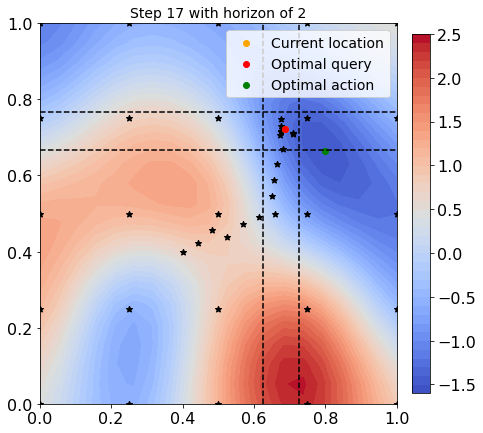

  1%|          | 1/100 [00:00<00:21,  4.53it/s]

x0:  [[0.6924054026603699, 0.7447699904441833]] , a:  [[0.7247292399406433, 0.7770169377326965]] , loss:  -0.6318703957144138


 11%|█         | 11/100 [00:02<00:20,  4.32it/s]

x0:  [[0.7086916565895081, 0.7241380214691162]] , a:  [[0.7721694707870483, 0.713060200214386]] , loss:  -0.7226974159485646


 21%|██        | 21/100 [00:04<00:16,  4.69it/s]

x0:  [[0.7021270394325256, 0.7220473289489746]] , a:  [[0.7592189311981201, 0.6986173391342163]] , loss:  -0.7374941429054923


 31%|███       | 31/100 [00:06<00:14,  4.64it/s]

x0:  [[0.6990779638290405, 0.7284968495368958]] , a:  [[0.7596214413642883, 0.7046331167221069]] , loss:  -0.745667193339416


 41%|████      | 41/100 [00:08<00:12,  4.77it/s]

x0:  [[0.6937258839607239, 0.7314639091491699]] , a:  [[0.7652804851531982, 0.7011094689369202]] , loss:  -0.7544883424332286


 51%|█████     | 51/100 [00:11<00:10,  4.59it/s]

x0:  [[0.6878728270530701, 0.7328117489814758]] , a:  [[0.7671234607696533, 0.6952800750732422]] , loss:  -0.759516811350521


 61%|██████    | 61/100 [00:13<00:08,  4.81it/s]

x0:  [[0.6840107440948486, 0.7349315881729126]] , a:  [[0.767127275466919, 0.6947629451751709]] , loss:  -0.7607284716013334


 71%|███████   | 71/100 [00:15<00:06,  4.64it/s]

x0:  [[0.6869160532951355, 0.738571286201477]] , a:  [[0.7726239562034607, 0.6994391083717346]] , loss:  -0.7629840771219959


 81%|████████  | 81/100 [00:17<00:03,  4.87it/s]

x0:  [[0.6911178827285767, 0.742282509803772]] , a:  [[0.7793563604354858, 0.7053927779197693]] , loss:  -0.7658469711506447


 91%|█████████ | 91/100 [00:19<00:01,  4.62it/s]

x0:  [[0.6994353532791138, 0.7447920441627502]] , a:  [[0.790578305721283, 0.7082470059394836]] , loss:  -0.7705012881147533


100%|██████████| 100/100 [00:21<00:00,  4.65it/s]


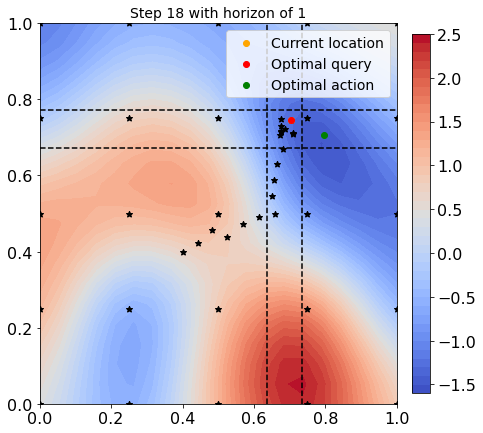

  4%|▍         | 4/100 [00:00<00:06, 15.68it/s]

x0:  [[0.7161556482315063, 0.7561873197555542]] , a:  [[0.736362874507904, 0.7657449841499329]] , loss:  -0.223822278896326


 14%|█▍        | 14/100 [00:00<00:05, 15.14it/s]

x0:  [[0.7340973615646362, 0.7328134775161743]] , a:  [[0.7693087458610535, 0.7188213467597961]] , loss:  -0.24397384084141271


 22%|██▏       | 22/100 [00:01<00:06, 12.37it/s]

x0:  [[0.7366069555282593, 0.7191483378410339]] , a:  [[0.7758241295814514, 0.6911311745643616]] , loss:  -0.24647454937581195


 32%|███▏      | 32/100 [00:02<00:05, 11.65it/s]

x0:  [[0.7377846240997314, 0.7145959138870239]] , a:  [[0.7785546779632568, 0.6819717884063721]] , loss:  -0.24633259478748185


 42%|████▏     | 42/100 [00:03<00:04, 11.76it/s]

x0:  [[0.7394005656242371, 0.714294970035553]] , a:  [[0.7810935974121094, 0.6811591982841492]] , loss:  -0.2463061655307385


 52%|█████▏    | 52/100 [00:04<00:03, 12.09it/s]

x0:  [[0.739311695098877, 0.715532660484314]] , a:  [[0.7809480428695679, 0.6833353638648987]] , loss:  -0.24637917424563094


 62%|██████▏   | 62/100 [00:05<00:03, 10.97it/s]

x0:  [[0.7378264665603638, 0.7170820236206055]] , a:  [[0.7787588238716125, 0.6861552000045776]] , loss:  -0.24645970425654237


 74%|███████▍  | 74/100 [00:05<00:01, 14.92it/s]

x0:  [[0.7367032170295715, 0.718462347984314]] , a:  [[0.7771270275115967, 0.6886288523674011]] , loss:  -0.24648710091725


 84%|████████▍ | 84/100 [00:06<00:00, 16.53it/s]

x0:  [[0.7363632917404175, 0.7193685173988342]] , a:  [[0.7767685651779175, 0.6900877356529236]] , loss:  -0.24648936806549804


 94%|█████████▍| 94/100 [00:07<00:00, 16.49it/s]

x0:  [[0.7359433174133301, 0.7197304368019104]] , a:  [[0.7765167951583862, 0.6903634071350098]] , loss:  -0.2464913466606816


100%|██████████| 100/100 [00:07<00:00, 13.42it/s]


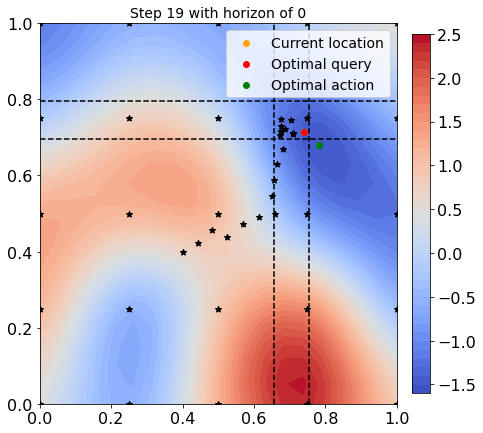

In [8]:
#@title 2D

if twoD:
    save = True
    n_dim = 2
    dim_xi = [1, n_dim]
    prev_x = torch.tensor([[0.4, 0.4]])
    neighbor_size = 0.05
    budget = 20

    ehig_opt_epoch = 100
    ehig_opt_lr = 0.1
    use_lr_schedule = False
    train = False

    train_x, train_y = init_data(n_init=5)

    model = init_model(
        n_dim=n_dim, prev_x=prev_x, 
        train_x=train_x, train_y=train_y,
        train=train)
    
    horizon = budget
    for step in range(budget):

        best_result = argmax_ehig(
            model, prev_x, horizon=horizon, 
            ehig_opt_epoch=ehig_opt_epoch, 
            ehig_opt_lr=ehig_opt_lr, 
            neighbor_size=neighbor_size,
            use_lr_schedule=use_lr_schedule)
        
        horizon = horizon - 1

        next_x = best_result[0]
        next_y = func(next_x.reshape(-1, n_dim))

        # update data and model
        train_x = torch.cat([train_x, next_x.reshape(-1, n_dim)])
        train_y = torch.cat([train_y, next_y])

        model = init_model(
            n_dim=n_dim, prev_x=prev_x, 
            train_x=train_x, train_y=train_y,
            train=train)

        plt.title(f'Step {step} with horizon of {horizon}')

        draw_posterior(n_dim=n_dim, model=model)

        plt.hlines(prev_x[0, 1] - neighbor_size, 0, 1, linestyle='--')
        plt.hlines(prev_x[0, 1] + neighbor_size, 0, 1, linestyle='--')

        plt.vlines(prev_x[0, 0] - neighbor_size, 0, 1, linestyle='--')
        plt.vlines(prev_x[0, 0] + neighbor_size, 0, 1, linestyle='--')
        prev_x = next_x 

        plt.scatter(train_x[:, 0], train_x[:, 1], 
                    marker='*', color='black')
        plt.scatter(prev_x[0, 0], prev_x[0, 1], 
                    color='orange', label='Current location')
        plt.scatter(best_result[0][0, 0], best_result[0][0, 1], 
                    color='red', label='Optimal query')
        plt.scatter(best_result[-1][0, 0], best_result[-1][0, 1], 
                    color='green', label='Optimal action')

        plt.legend()

        if save: plt.savefig(
            f'{path}/2D/step{step}.{imgtype}', 
            dpi=dpi, bbox_inches='tight')

        plt.show()